In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta

sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")


In [2]:
folder = '/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/raw_data'

filelist = [file for file in os.listdir(folder) if file.startswith('dataland')]
for file in filelist:
    exec("%s = pd.read_csv('%s')" % (file.split('.')[0], os.path.join(folder,file)))

Some EDA.

In [3]:
res_columns_to_rename = {
    'cc_share': 'cc',
    'dgm_share': 'dgm',
    'pdal_share': 'pdal',
    'ssp_share': 'ssp'
}
res_df = dataland_election_results_1984_2023.rename(columns=res_columns_to_rename)
res_df['vote_share_type'] = "observed"
res_df = res_df[['year', 'province', 'cc', 'dgm', 'pdal','ssp', 'vote_share_type']]
res_df['undecided'] = np.NaN


poll_columns_to_rename = {
    'cc_poll_share': 'cc',
    'dgm_poll_share': 'dgm',
    'pdal_poll_share': 'pdal',
    'ssp_poll_share': 'ssp',
    'undecided_poll_share': 'undecided'
}

poll_df = dataland_polls_1984_2023_updated.rename(columns=poll_columns_to_rename)
poll_df['vote_share_type'] = "poll"
poll_df = poll_df.rename(columns={"geography":"province"})
poll_df = poll_df[['year', 'province', 'cc', 'dgm', 'pdal','ssp', 'undecided', 'vote_share_type']]

merged_df = pd.concat([res_df, poll_df])



It looks like the undecided share is not significantly impacting the vote share outcomes on average since the poll trends and outcome trends are similar. 

The more important factor could be the manipulation of polling vote shares due to housing effects, i.e. party-sponsored polls. 

(Caveat: there could be more influence of the undecided share within election cycles.)

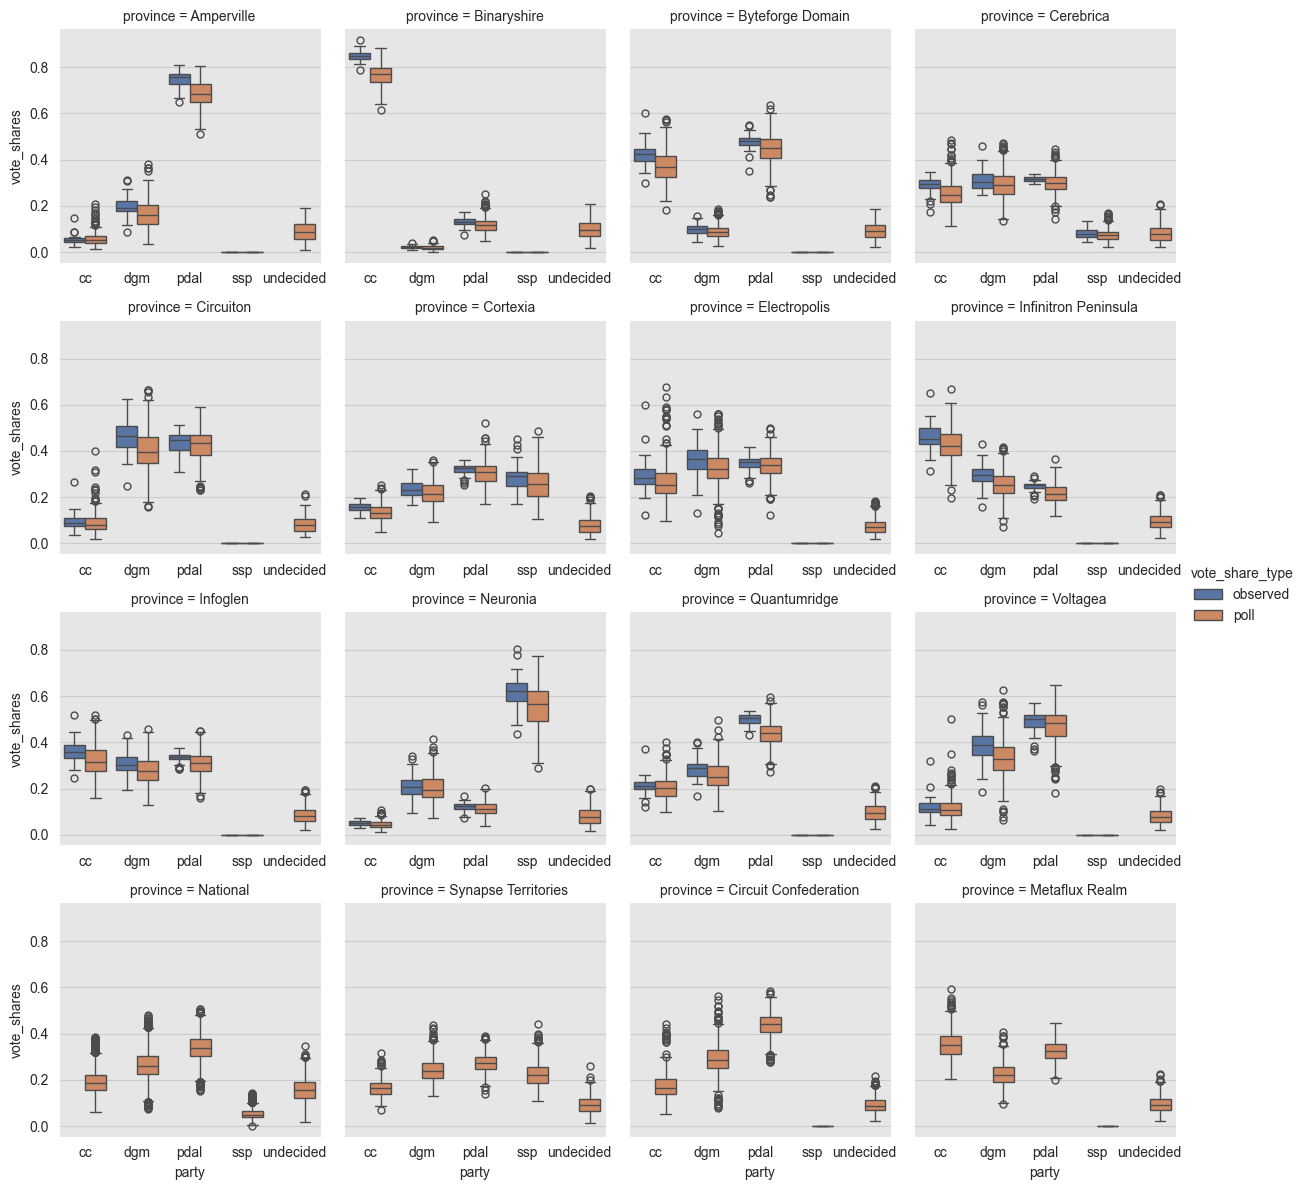

In [5]:
merged_df_long = merged_df.melt(id_vars=['year', 'province', 'vote_share_type'], 
                                value_vars=['cc', 'dgm', 'pdal', 'ssp', 'undecided'] , 
                                var_name='party', 
                                value_name='vote_shares')



sns.catplot(x = 'party', y='vote_shares', hue='vote_share_type', col='province', col_wrap=4,
            kind='box', data=merged_df_long, sharex=False, height=3)

Check whether the polls bringing down/up an average that change the election share ranking looks to be from sponsored polls. 

The two provinces that seem to have this is Circuiton and Electropolis. DGM in both provinces on average over all elections has a lower share that shifts their position in observed election results. 

Across all the sponsored polls by geo, DGM's lowest number of sponsored polls is in the two affected provinces. 


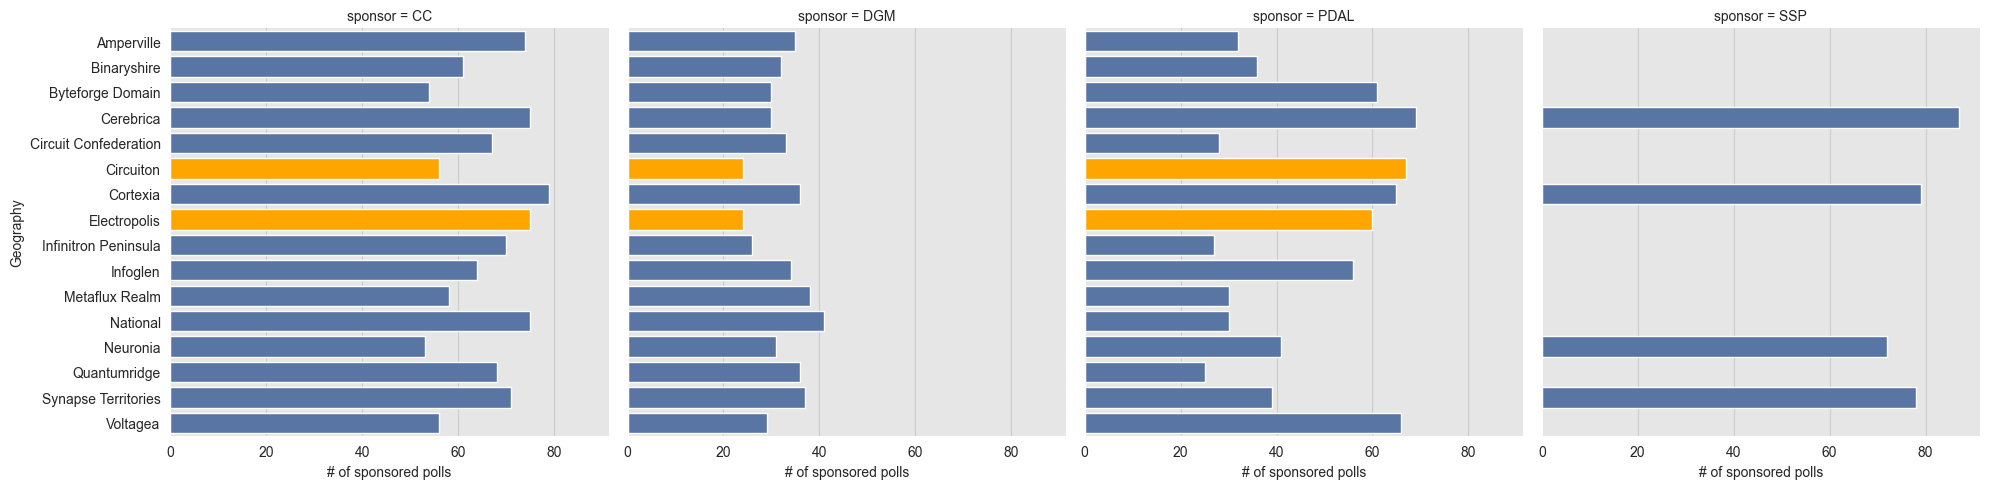

In [6]:
sponsored_polls_by_province = dataland_polls_1984_2023_updated.groupby(['sponsor', 'geography']).date_published.count().reset_index()

highlighted_geo = ['Circuiton','Electropolis']

g = sns.catplot(sponsored_polls_by_province, x='date_published', y='geography', col='sponsor', kind='bar')
# g.set_axis_labels("# of sponsored polls", "Geography")

# Highlight the specific bars using the mask
for ax in g.axes.flat:
    bars = ax.patches
    for bar, sponsor in zip(bars, sponsored_polls_by_province['geography']):
        if sponsor in highlighted_geo:
            bar.set_facecolor('orange')   # Set a different color for highlighted bars

# Set axis labels and titles
g.set_axis_labels("# of sponsored polls", "Geography")


Check the vote shares for each party by election cycle. 

It looks like half the provinces have competitive races while the other half one party is clearly favored. 

SSP party seems to only gain vote share or run at all in 3 provinces. These provinces are from the same region. 

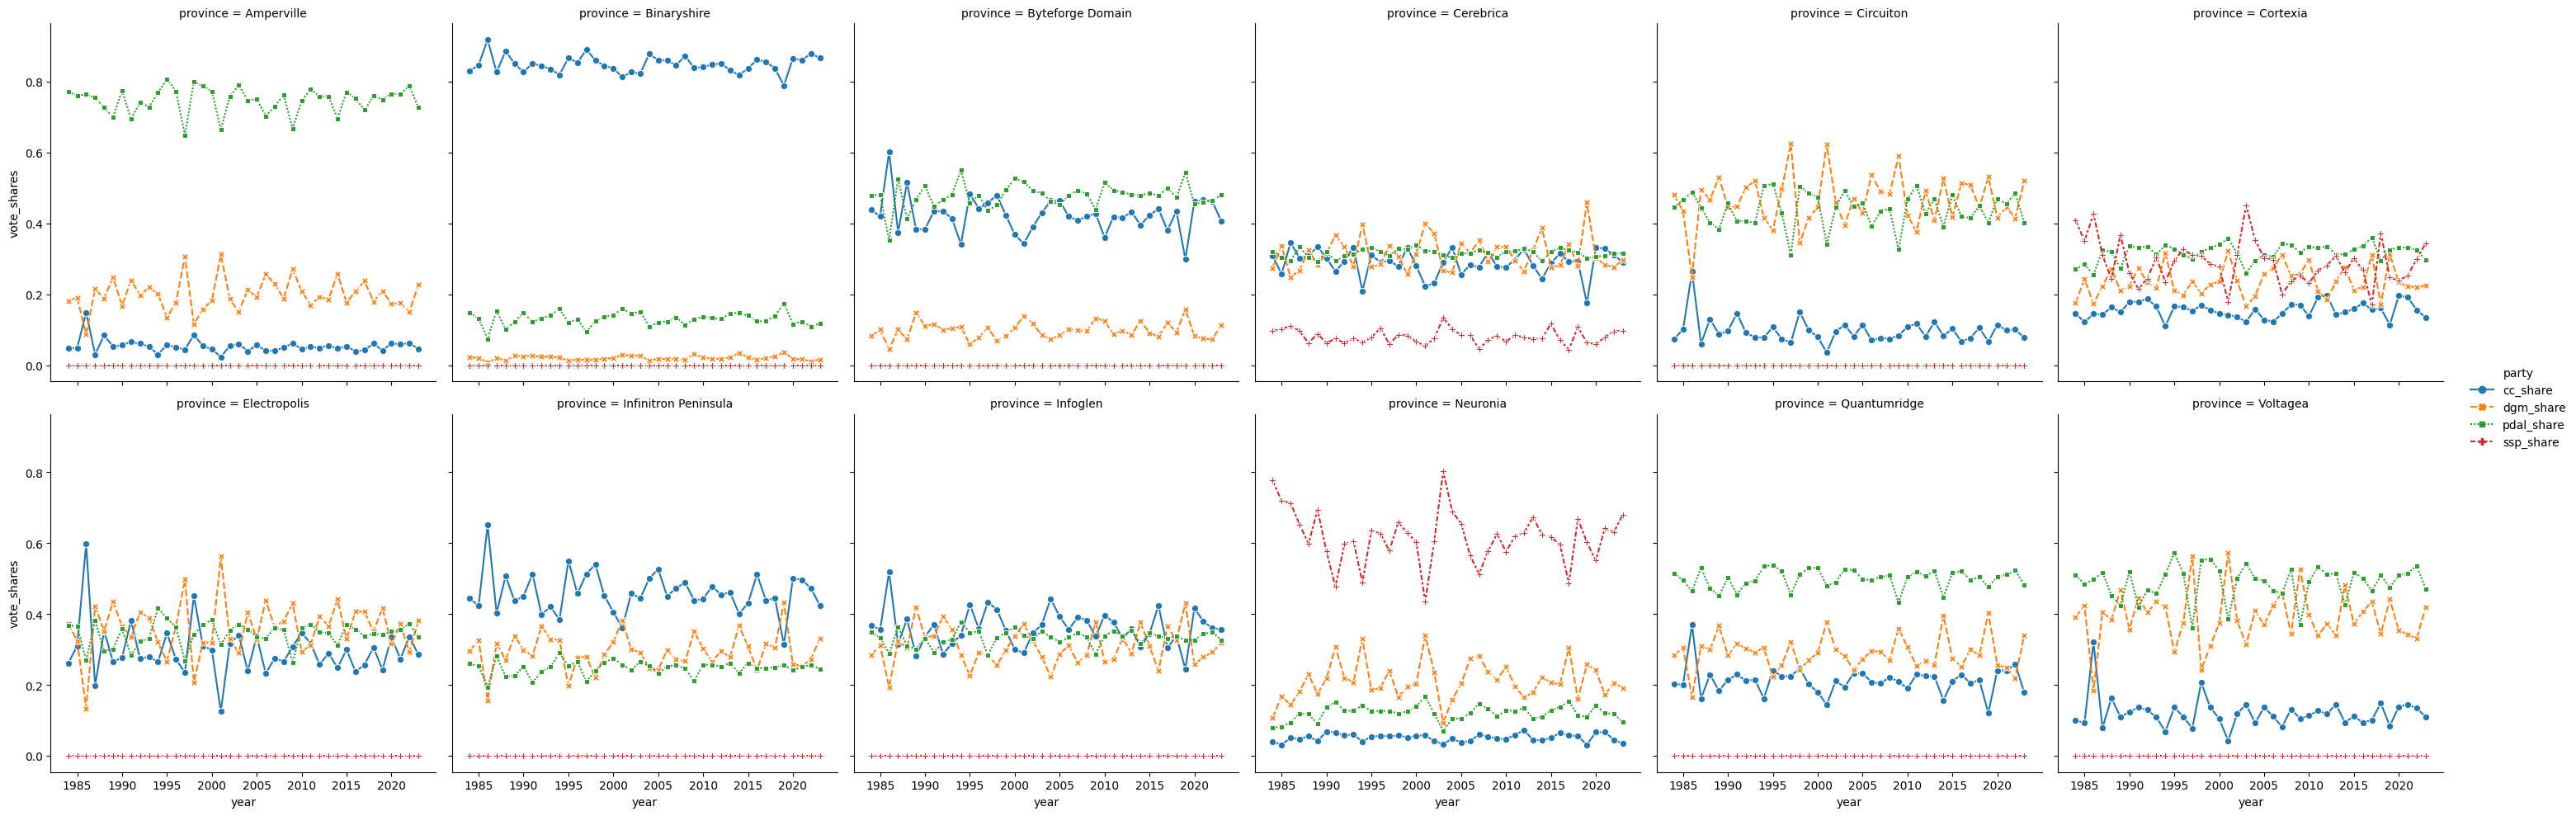

In [72]:
df_y_long = dataland_election_results_1984_2023.melt(id_vars=['year', 'province', 'region'], 
                                value_vars=['cc_share', 'dgm_share', 'pdal_share', 'ssp_share'] , 
                                var_name='party', 
                                value_name='vote_shares')

sns.relplot(x='year', y='vote_shares', hue='party', col='province', col_wrap=6,
            kind='line', data=df_y_long, markers=True, style='party')

In [121]:
dataland_election_results_1984_2023.groupby('region').province.unique()

region
Circuit Confederation      [Amperville, Circuiton, Electropolis, Voltagea]
Metaflux Realm           [Binaryshire, Byteforge Domain, Infinitron Pen...
Synapse Territories                        [Cerebrica, Cortexia, Neuronia]
Name: province, dtype: object

In [130]:
dataland_economic_data_1984_2023['year'] = pd.DatetimeIndex(dataland_economic_data_1984_2023['date']).year
df_structural = dataland_election_results_1984_2023.merge(dataland_economic_data_1984_2023, on='year', how='left').merge(dataland_demographics, on=['province', 'region'])


In [119]:
dep_cols = ['cc_share', 'dgm_share', 'pdal_share', 'ssp_share']
demographic_cols = ['population', 'python_pop_share', 'cobolite_pop_share', 'javarian_pop_share']
econ_cols = ['year_on_year_gdp_pct_change', 'unemployment_rate', 'year_on_year_inflation','year_on_year_stock_mkt_pct_change']

I look at correlation plots among the possible economic and demographic variables stratified by province. The plots tell me that a province level model would yield the same information as the demographic data (which makes sense since this data doesn't vary over time). Economic indicators are highly correlated with vote share outcomes within provinces but they do have some variance so we should include them in the model. 

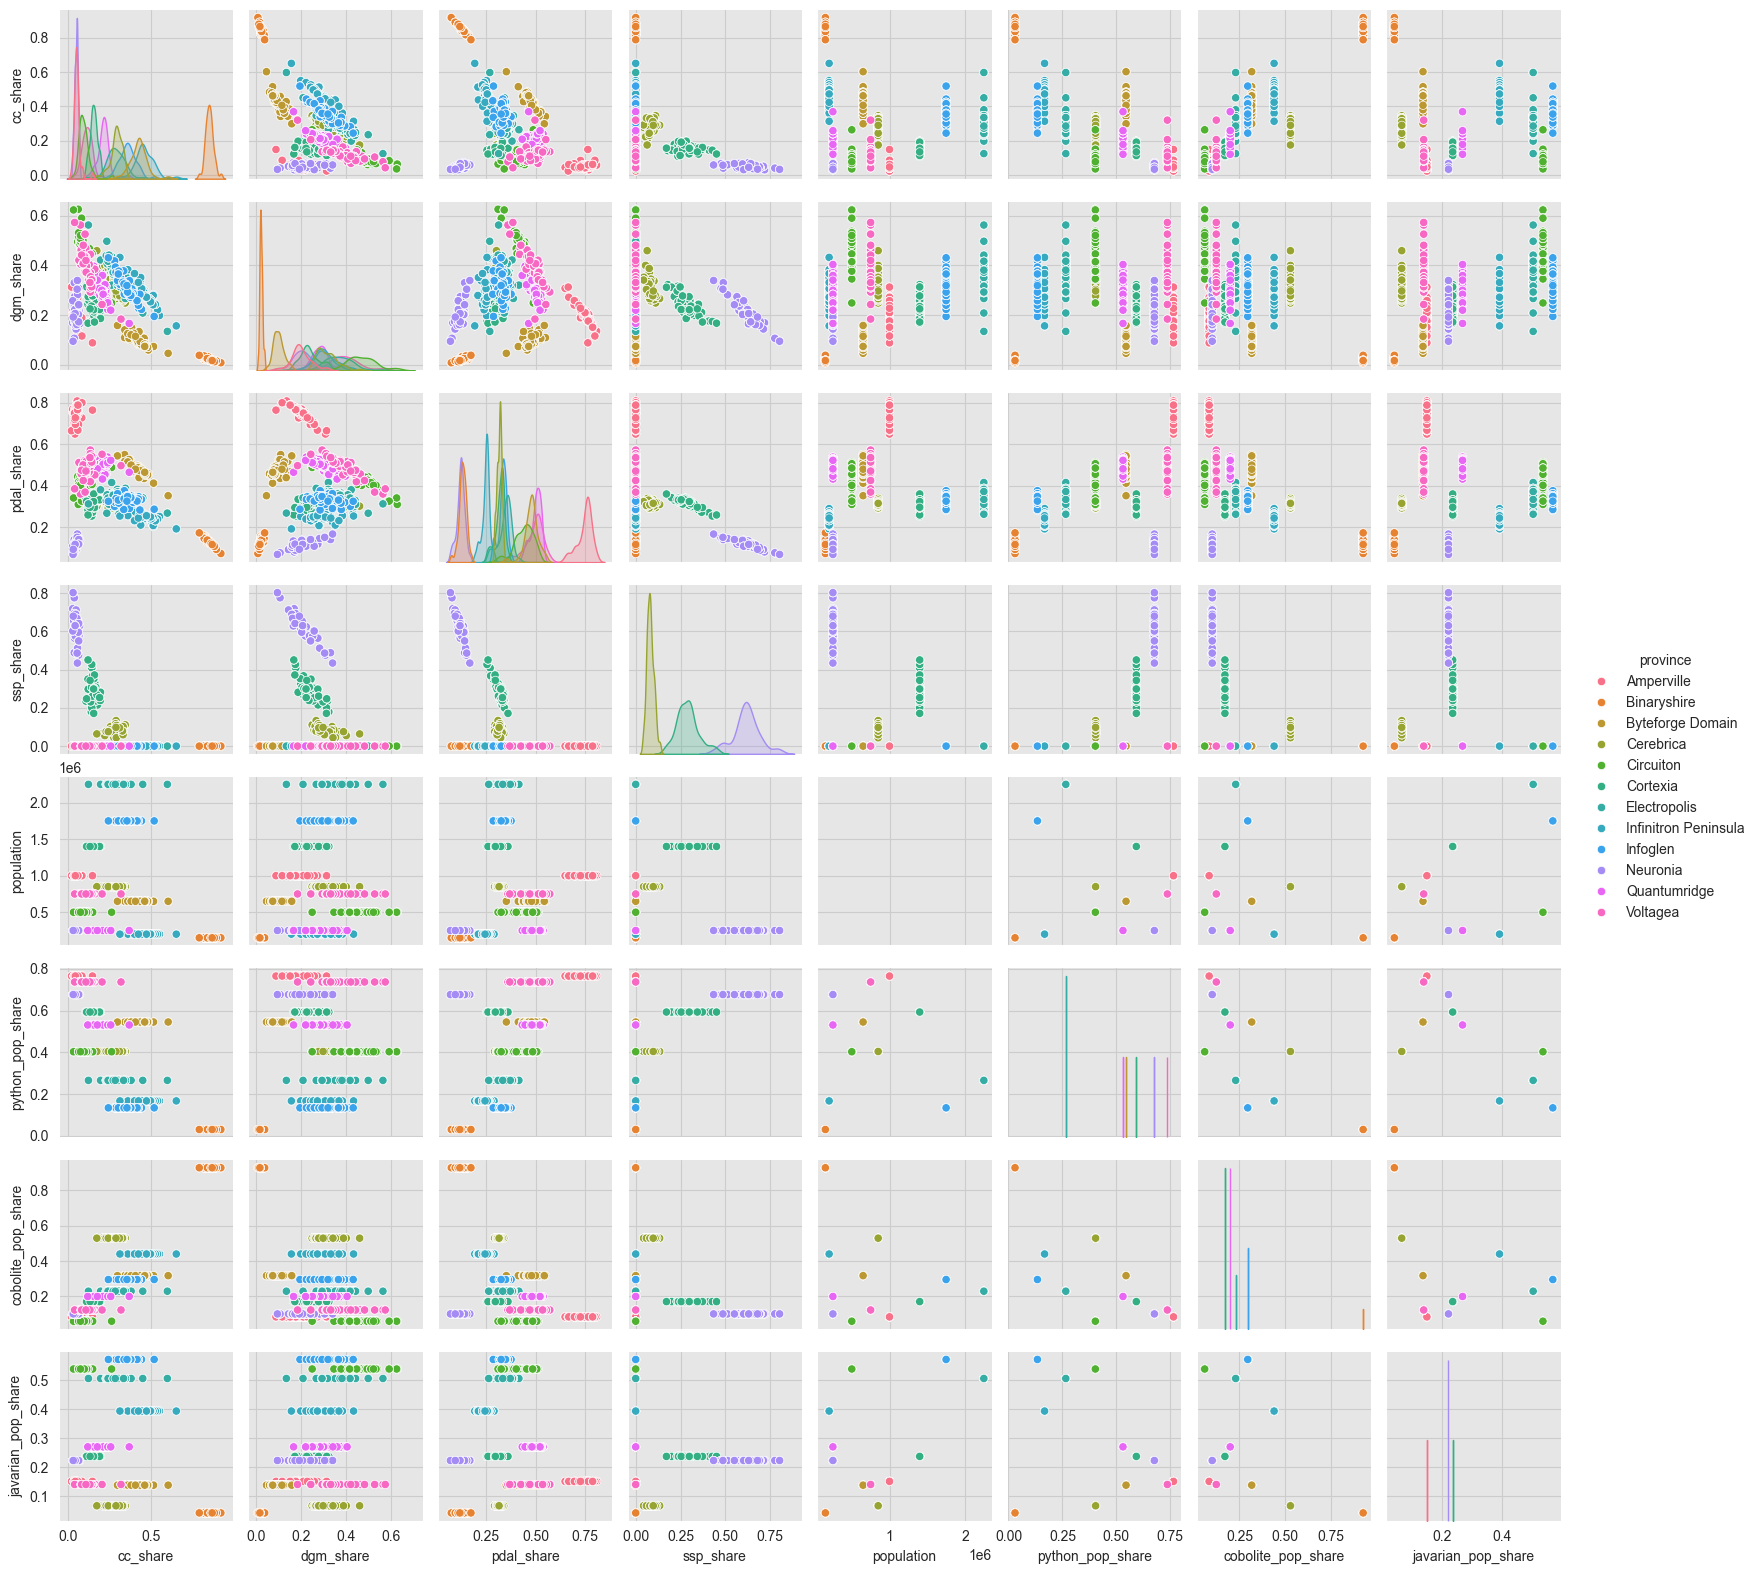

In [129]:
sns.pairplot(
    data=df_structural[dep_cols+demographic_cols+['province']], kind="scatter", height=2, plot_kws={"color": sns_c[1]}, diag_kws={"color": sns_c[2]}, hue='province'
)


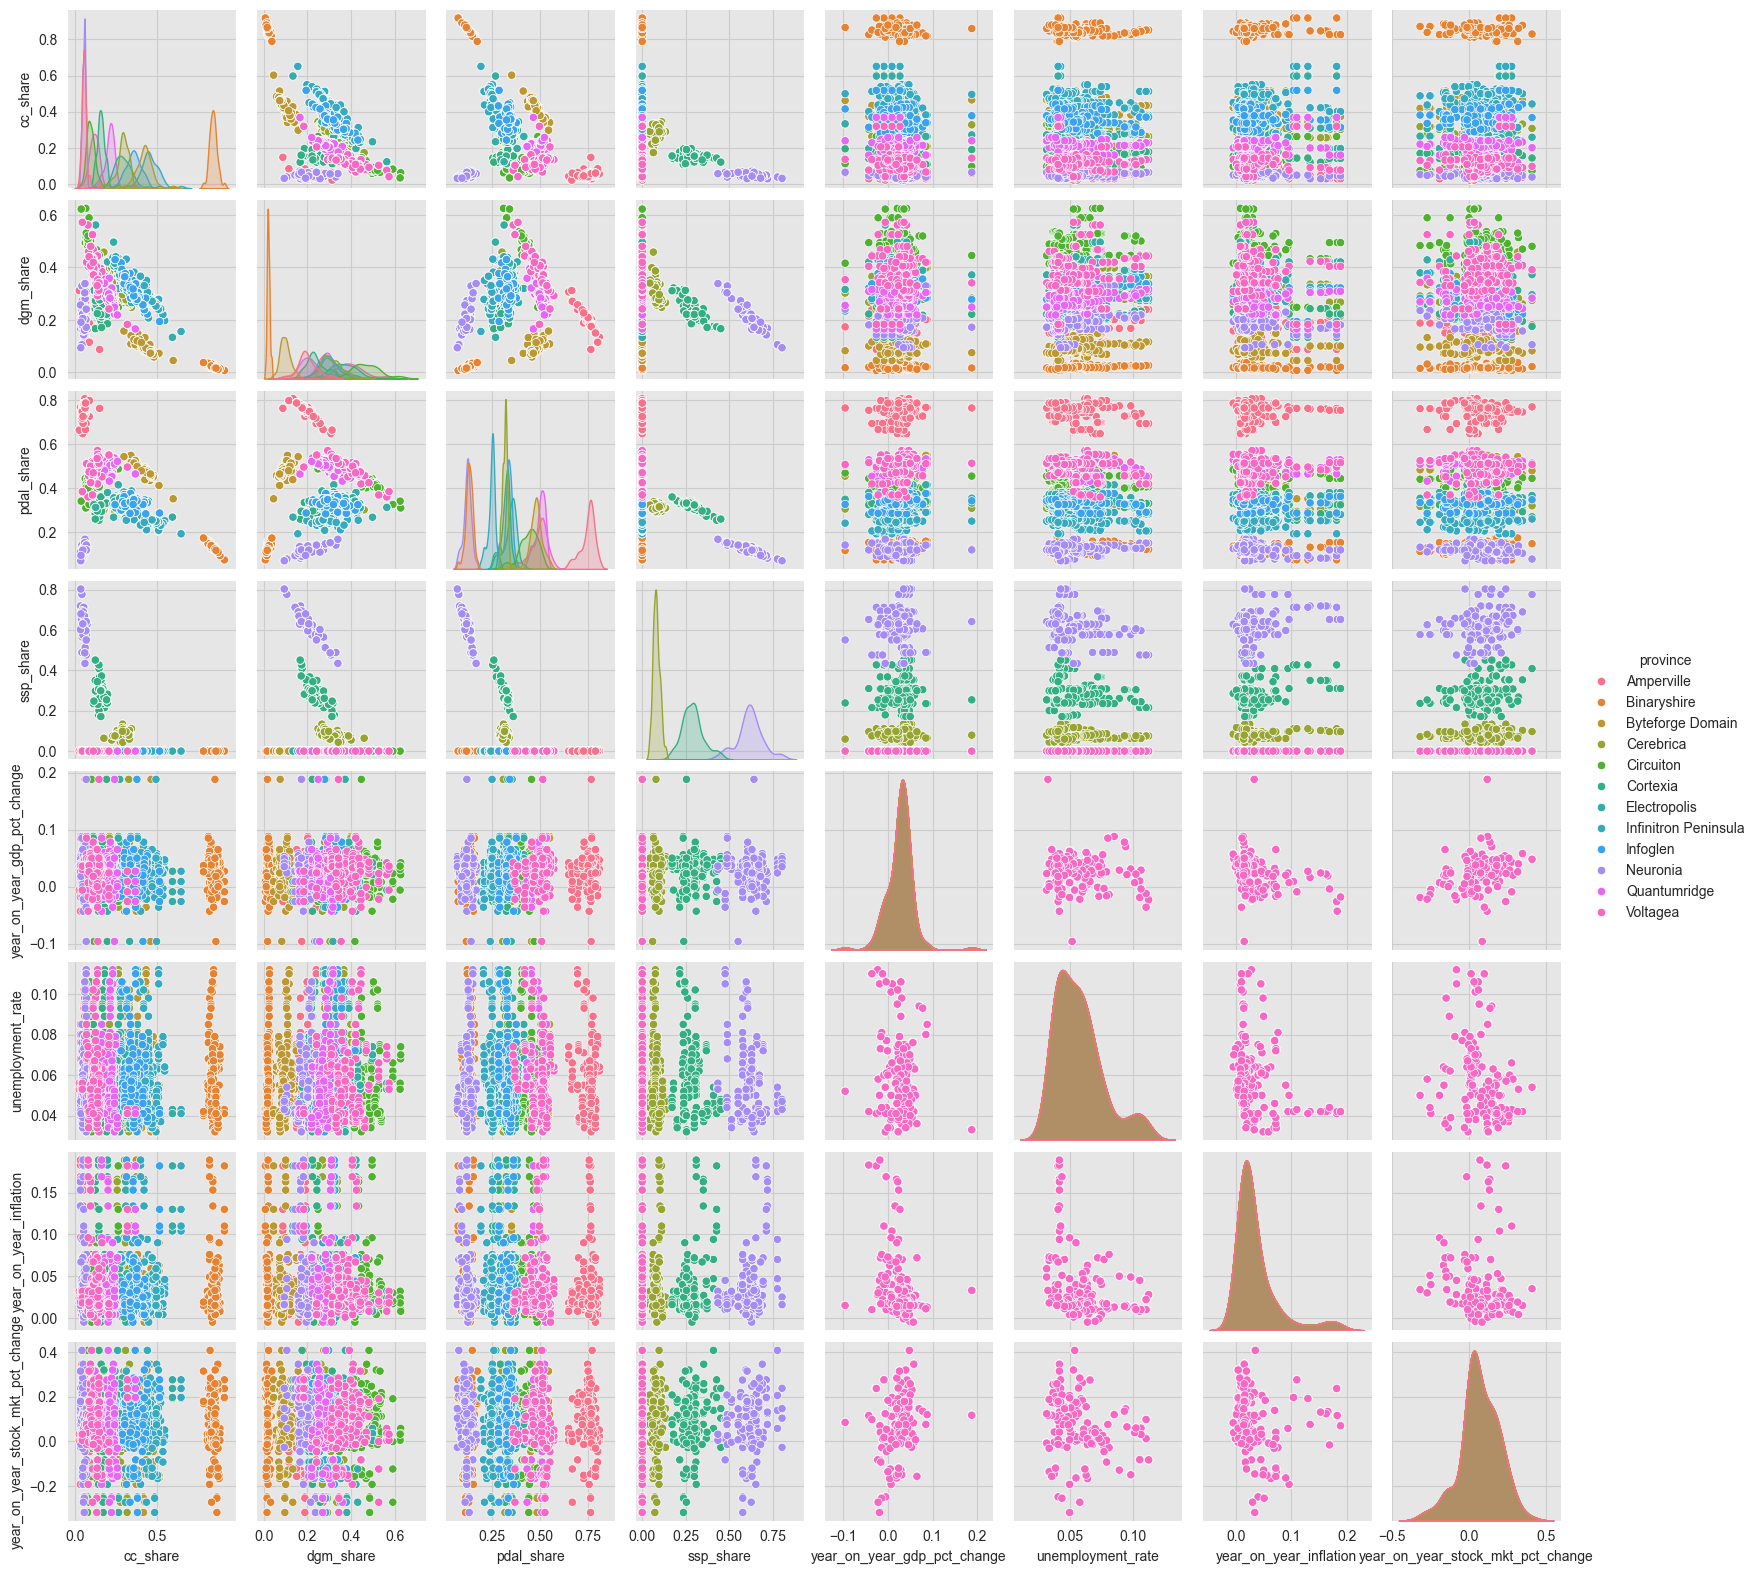

In [128]:
sns.pairplot(
    data=df_structural[dep_cols+econ_cols+['province']], kind="scatter", height=2, plot_kws={"color": sns_c[1]}, diag_kws={"color": sns_c[2]}, hue='province'
)

So far, I will include economic variables in the model. Let's look at party in power, the incumbent indicator. Let's also generate a previous year national pop vote winner. 

In [171]:
res_df = dataland_election_results_1984_2023.sort_values(by=['province', 'year'], ascending=True)

res_df['previous_year_national_pop_vote_winner'] = res_df.groupby(['province'])['national_pop_vote_winner'].shift()
res_df['previous_year_provincial_winner'] = res_df.groupby(['province'])['provincial_winner'].shift()

In [172]:
res_df.groupby(['previous_year_national_pop_vote_winner', 'party_in_power']).size().reset_index(name='count')

previous_year_national_pop_vote_winner party_in_power  count
0                                     cc             cc     12
1                                    dgm            dgm     36
2                                   pdal             cc     36
3                                   pdal            dgm     72
4                                   pdal           pdal    312

In [173]:
res_df.groupby(['previous_year_provincial_winner', 'provincial_winner']).size().reset_index(name='count')

previous_year_provincial_winner provincial_winner  count
0                               cc                cc     95
1                               cc               dgm     14
2                               cc              pdal     14
3                              dgm                cc     15
4                              dgm               dgm     30
5                              dgm              pdal     33
6                             pdal                cc     13
7                             pdal               dgm     34
8                             pdal              pdal    167
9                             pdal               ssp      5
10                             ssp              pdal      5
11                             ssp               ssp     43

In [174]:
res_df.columns

Index(['year', 'province', 'region', 'party_in_power', 'provincial_winner',
       'national_winner', 'national_pop_vote_winner', 'cc_share', 'dgm_share',
       'pdal_share', 'ssp_share', 'previous_year_national_pop_vote_winner',
       'previous_year_provincial_winner'],
      dtype='object')

Provincial level previous year winner seems to be highly correlated with some provinces (concentration of vote shares in one party), but not so much the case nationally. 


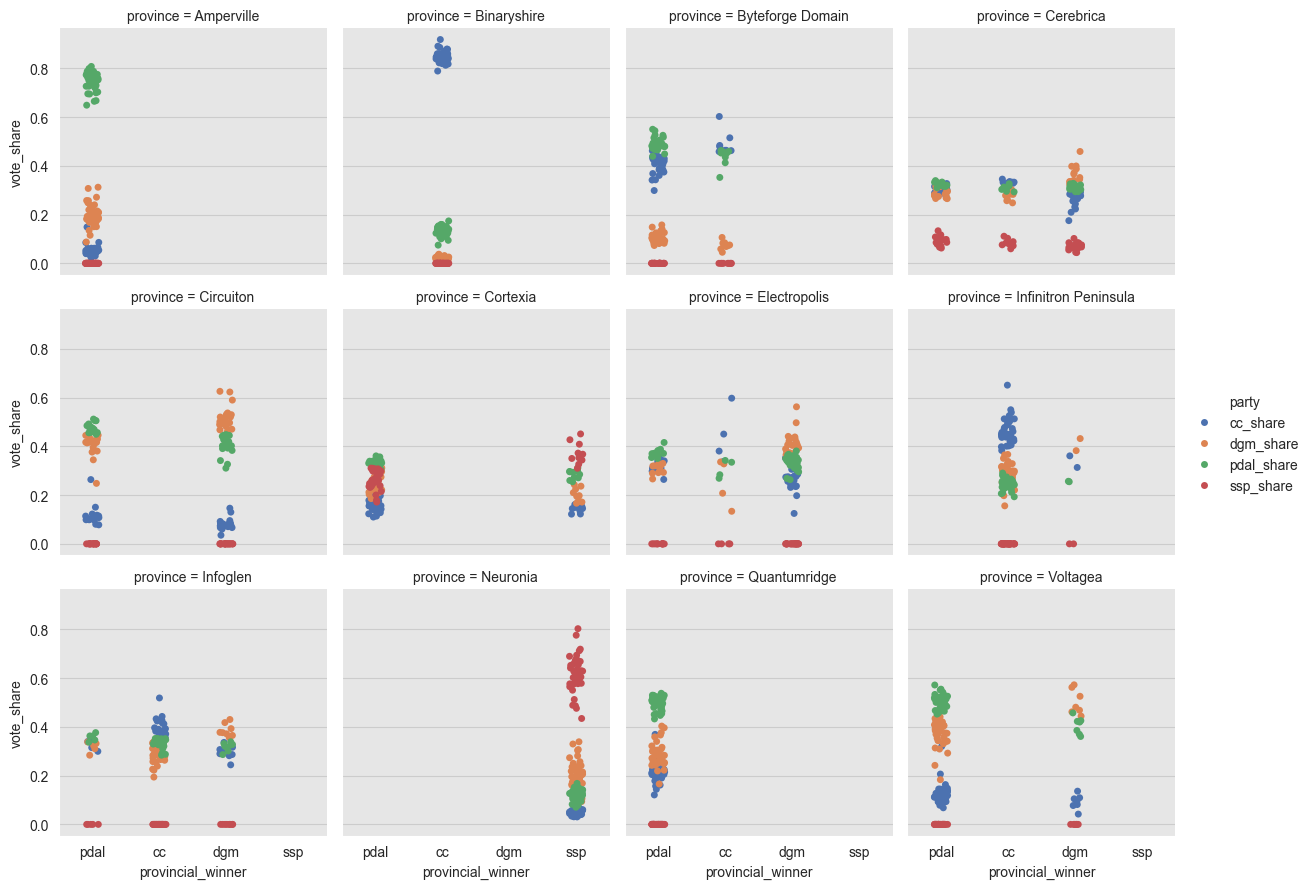

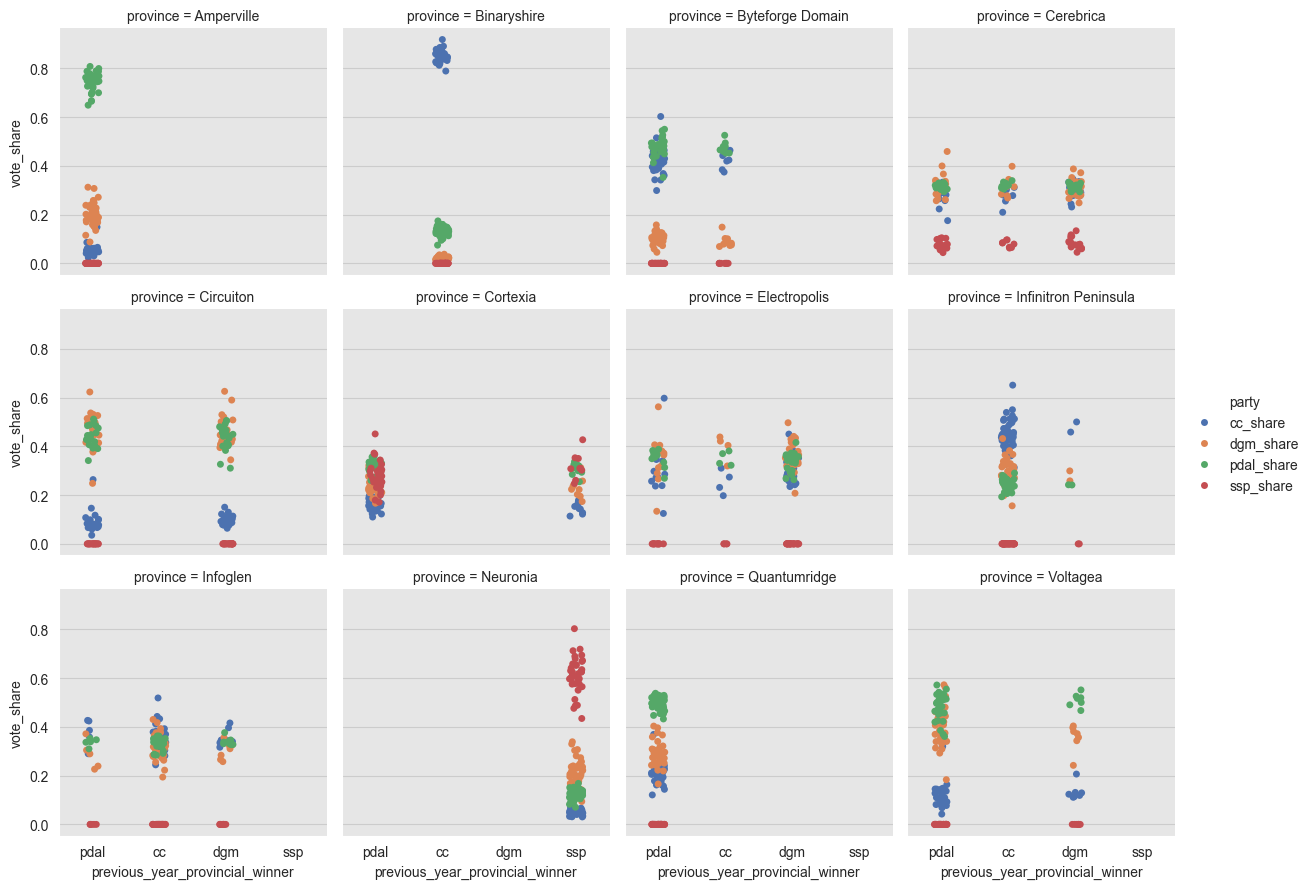

In [178]:
res_df_long = res_df.melt(
    id_vars=['year', 'province', 'region', 'party_in_power', 'provincial_winner', 'national_winner', 'national_pop_vote_winner', 'previous_year_national_pop_vote_winner', 'previous_year_provincial_winner'], 
    var_name='party',
    value_name='vote_share'
    )

# current election cycle winner correlation with vote shares
sns.catplot(res_df_long, x='provincial_winner', y='vote_share', hue='party', col='province', col_wrap=4, height=3)

# last year vote winner correlation with vote shares
sns.catplot(res_df_long, x='previous_year_provincial_winner', y='vote_share', hue='party', col='province', col_wrap=4, height=3)

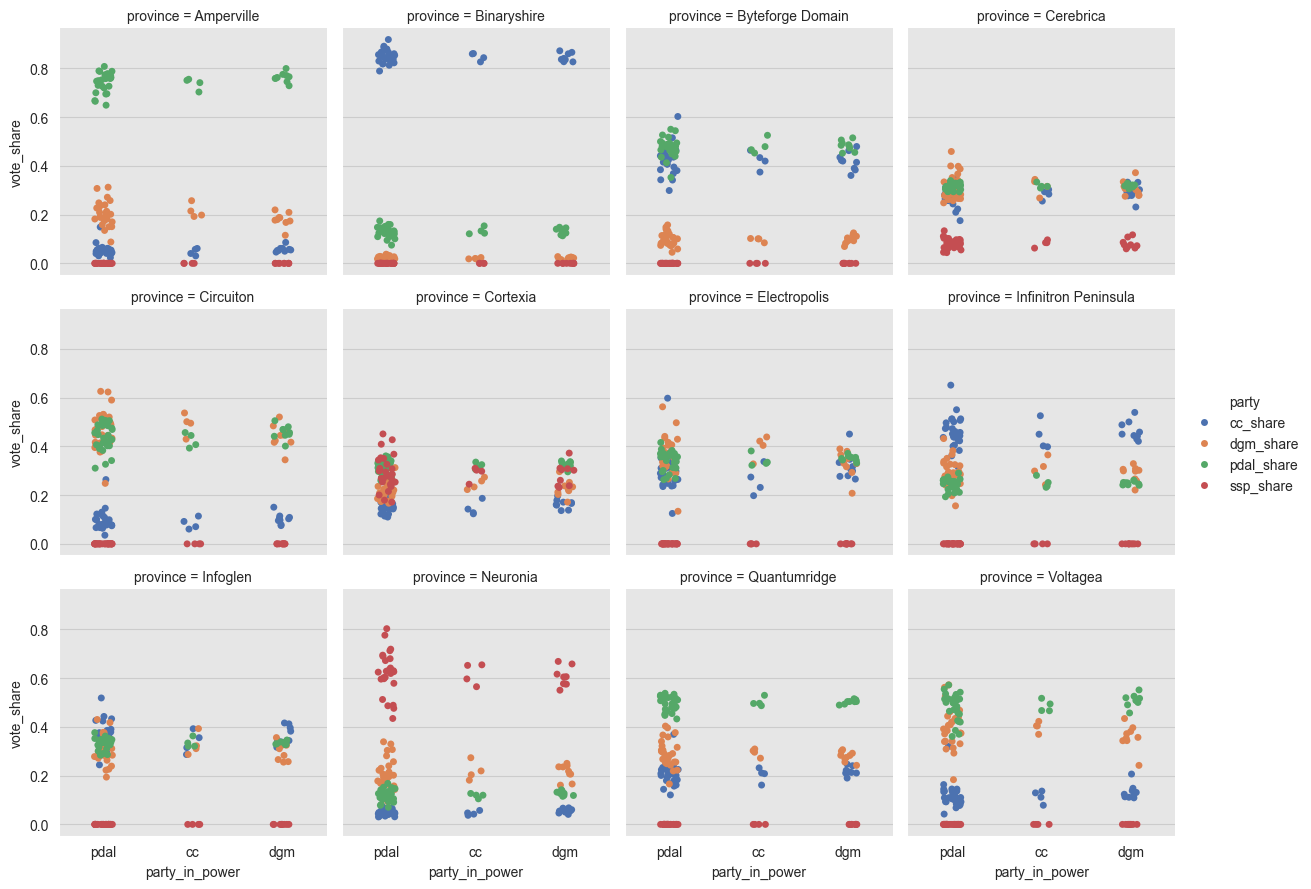

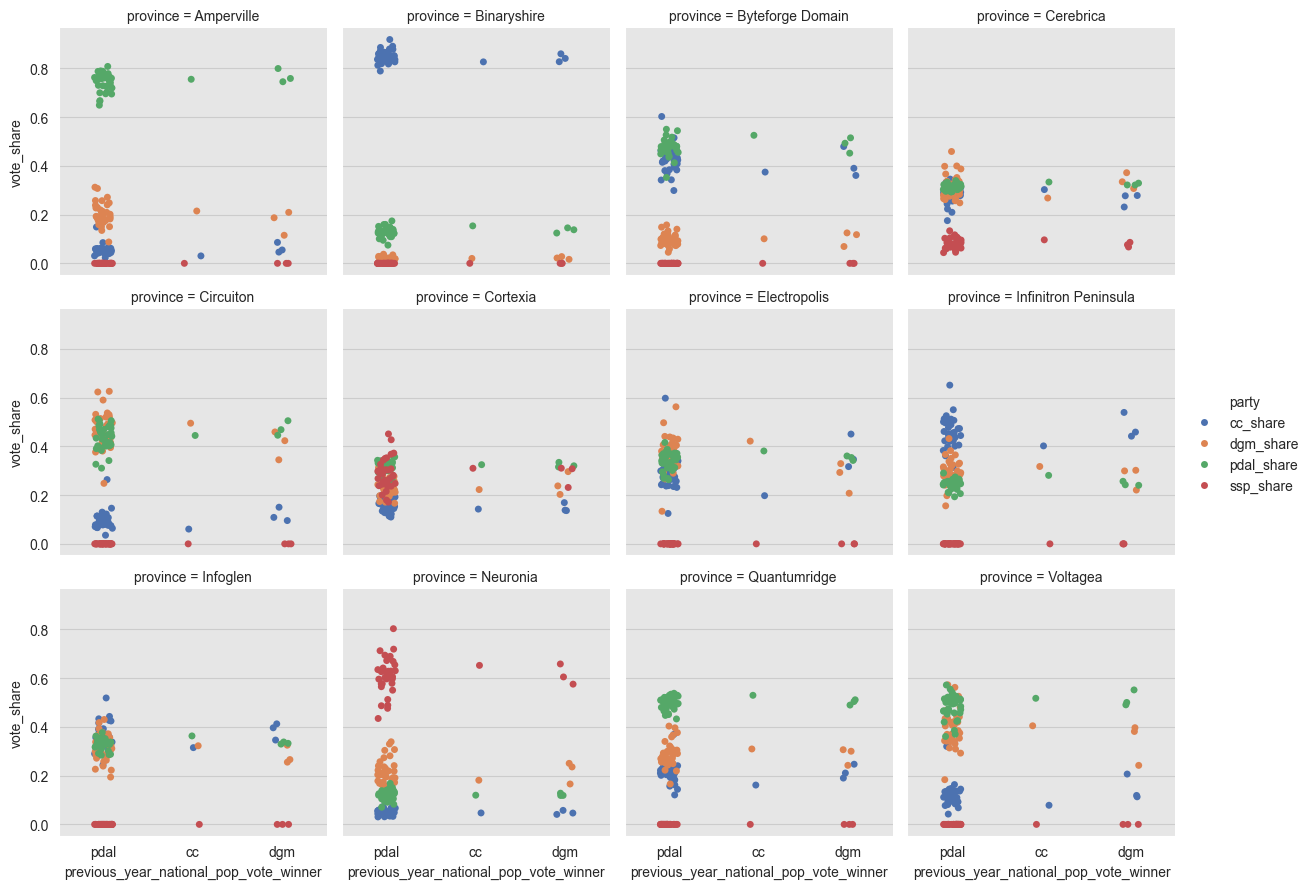

In [170]:
res_df_long = res_df.melt(
    id_vars=['year', 'province', 'region', 'party_in_power', 'provincial_winner', 'national_winner', 'national_pop_vote_winner', 'previous_year_national_pop_vote_winner'], 
    var_name='party',
    value_name='vote_share'
    )


# res_df_long = res_df_long[res_df_long['previous_year_national_pop_vote_winner'] != res_df_long['party_in_power']]

# incumbent correlation with vote shares
sns.catplot(res_df_long, x='party_in_power', y='vote_share', hue='party', col='province', col_wrap=4, height=3)

# last year national vote winner correlation with vote shares
sns.catplot(res_df_long, x='previous_year_national_pop_vote_winner', y='vote_share', hue='party', col='province', col_wrap=4, height=3)

Let's  check calendar event dates. Earliest party activity for the campaign is ~2 months before election day. 

In [50]:
# dataland_electoral_calendar = dataland_electoral_calendar.rename(columns={'election_cycle': 'year'})
# dataland_electoral_calendar_long = dataland_electoral_calendar.melt(id_vars=['year', 'election_day'], var_name='calendar_event', value_name='calendar_event_date')
# dataland_electoral_calendar_long['calendar_event_date'] = pd.to_datetime(dataland_electoral_calendar_long['calendar_event_date'])
# dataland_electoral_calendar_long['election_day'] = pd.to_datetime(dataland_electoral_calendar_long['election_day'])
# dataland_electoral_calendar_long.describe()

In [51]:
# dataland_polls_1984_2023_updated['date_conducted'] = pd.DatetimeIndex(dataland_polls_1984_2023_updated['date_conducted'])
# dataland_polls_1984_2023_updated['date_published'] = pd.DatetimeIndex(dataland_polls_1984_2023_updated['date_published'])


In [47]:
# df_calendar = dataland_electoral_calendar.merge(dataland_polls_1984_2023_updated, on='year', how='inner')
# df_calendar = df_calendar[df_calendar['year'] == 2022]

# df_calendar_long = df_calendar.melt(
#     id_vars = ['year', 'election_day', 'cc_conference_start_date',
#        'cc_conference_end_date', 'dgm_conference_start_date',
#        'dgm_conference_end_date', 'pdal_conference_start_date',
#        'pdal_conference_end_date', 'ssp_conference_start_date',
#        'ssp_conference_end_date', 'debate_date_1', 'debate_date_2',
#        'debate_date_3', 'date_conducted', 'date_published', 'pollster',
#        'geography', 'mode', 'sample_size', 'population_surveyed', 'sponsor'],
#     var_name = 'party',
#     value_name = 'vote_share'
#    )

Functions to process data. We join data on historical results (the ys) and explainer variables (the Xs), which we include economic data. 

In [196]:
folder = '/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/raw_data'

filelist = [file for file in os.listdir(folder) if file.startswith('dataland')]
for file in filelist:
    exec("%s = pd.read_csv('%s')" % (file.split('.')[0], os.path.join(folder,file)))

In [ ]:
dataland_economic_data_1984_2023

In [221]:
def create_structural_data(df_y, df_X_econ):
    """Steps:
    1. Process data
    2. Join processed X data to y data
    """
    # create year column
    df_X_econ['year'] = pd.DatetimeIndex(df_X_econ['date']).year
    # df_X_electoral.rename(columns={'election_cycle':'year'}, inplace=True)
    # df_X_electoral['year'] = pd.DatetimeIndex(df_X_electoral['election_day']).year

    # transform date cols to datetime
    # df_X_electoral['election_day'] = pd.to_datetime(df_X_electoral['election_day'])
    # df_X_polls['date_conducted'] = pd.to_datetime(df_X_polls['date_conducted'])
    # df_X_polls['date_published'] = pd.to_datetime(df_X_polls['date_published'])

    # mean economic data for the year
    # TODO: try other ways of summarize economic information
    df_X_econ_annual = df_X_econ.drop('date', axis=1).groupby('year').mean().reset_index()

    # create last year province winner; captures "incumbency" effect for the province 
    df_y['previous_year_provincial_winner'] = df_y.groupby(['province'])['provincial_winner'].shift()
    df_y['previous_year_provincial_winner'] = df_y['previous_year_provincial_winner'].fillna('None')
    df_y = pd.get_dummies(df_y, columns=['previous_year_provincial_winner'], drop_first=True)
    df_y[['previous_year_provincial_winner_cc',
       'previous_year_provincial_winner_dgm',
       'previous_year_provincial_winner_pdal',
       'previous_year_provincial_winner_ssp']] = df_y[['previous_year_provincial_winner_cc',
       'previous_year_provincial_winner_dgm',
       'previous_year_provincial_winner_pdal',
       'previous_year_provincial_winner_ssp']].astype(int) 

    # join all data together
    return df_y.merge(df_X_econ_annual, on='year', how='inner')


df_structural = create_structural_data(df_y=dataland_election_results_1984_2023, df_X_econ=dataland_economic_data_1984_2023)
df_structural.head()








year          province                 region party_in_power  \
0  1984        Amperville  Circuit Confederation           pdal   
1  1984       Binaryshire         Metaflux Realm           pdal   
2  1984  Byteforge Domain         Metaflux Realm           pdal   
3  1984         Cerebrica    Synapse Territories           pdal   
4  1984         Circuiton  Circuit Confederation           pdal   

  provincial_winner national_winner national_pop_vote_winner  cc_share  \
0              pdal            pdal                     pdal  0.047924   
1                cc            pdal                     pdal  0.829564   
2              pdal            pdal                     pdal  0.438357   
3              pdal            pdal                     pdal  0.308617   
4               dgm            pdal                     pdal  0.073943   

   dgm_share  pdal_share  ssp_share  previous_year_provincial_winner_cc  \
0   0.181743    0.770333   0.000000                                   0   
1   0.022409    0.148026   0.000000                                   0   
2   0.082160    0.479483   0.000000                                   0   
3   0.274261    0.320309   0.096813                                   0   
4   0.480847    0.445211   0.000000                                   0   

   previous_year_provincial_winner_dgm  previous_year_provincial_winner_pdal  \
0                                    0                                     0   
1                                    0                                     0   
2                                    0                                     0   
3                                    0                                     0   
4                                    0                                     0   

   previous_year_provincial_winner_ssp  year_on_year_gdp_pct_change  \
0                                    0                        0.036   
1                                    0                        0.036   
2                                    0                        0.036   
3                                    0                        0.036   
4                                    0                        0.036   

   unemployment_rate  year_on_year_inflation  \
0              0.048                  0.0615   
1              0.048                  0.0615   
2              0.048                  0.0615   
3              0.048                  0.0615   
4              0.048                  0.0615   

   year_on_year_stock_mkt_pct_change  
0                            0.20275  
1                            0.20275  
2                            0.20275  
3                            0.20275  
4                            0.20275

Data processing for polls data.

1. Check outliers
2. Weight by sample size, pop surveyed
3. Distribute region and national polls to province level
4. 

In [60]:
df_X_polls = dataland_polls_1984_2023_updated.copy()
df_X_polls['date_conducted'] = pd.to_datetime(df_X_polls['date_conducted'])
df_X_polls['date_published'] = pd.to_datetime(df_X_polls['date_published'])

In [61]:
df_X_polls[df_X_polls['year'] == 2022].groupby('geography').count()

year  date_conducted  date_published  pollster  mode  \
geography                                                                     
Amperville                7               7               7         7     7   
Binaryshire               6               6               6         6     6   
Byteforge Domain          9               9               9         9     9   
Cerebrica                14              14              14        14    14   
Circuit Confederation    13              13              13        13    13   
Circuiton                 6               6               6         6     6   
Cortexia                  9               9               9         9     9   
Electropolis             18              18              18        18    18   
Infinitron Peninsula     13              13              13        13    13   
Infoglen                 10              10              10        10    10   
Metaflux Realm           18              18              18        18    18   
National                 85              85              85        85    85   
Neuronia                  5               5               5         5     5   
Quantumridge             13              13              13        13    13   
Synapse Territories      14              14              14        14    14   
Voltagea                 10              10              10        10    10   

                       sample_size  population_surveyed  sponsor  \
geography                                                          
Amperville                       7                    7        3   
Binaryshire                      6                    6        1   
Byteforge Domain                 9                    9        1   
Cerebrica                       14                   14       10   
Circuit Confederation           13                   13        4   
Circuiton                        6                    6        1   
Cortexia                         9                    9        6   
Electropolis                    18                   18        7   
Infinitron Peninsula            13                   13        3   
Infoglen                        10                   10        2   
Metaflux Realm                  18                   18        7   
National                        85                   85        2   
Neuronia                         5                    5        4   
Quantumridge                    13                   13        5   
Synapse Territories             14                   14        5   
Voltagea                        10                   10        7   

                       cc_poll_share  dgm_poll_share  pdal_poll_share  \
geography                                                               
Amperville                         7               7                7   
Binaryshire                        6               6                6   
Byteforge Domain                   9               9                9   
Cerebrica                         14              14               14   
Circuit Confederation             13              13               13   
Circuiton                          6               6                6   
Cortexia                           9               9                9   
Electropolis                      18              18               18   
Infinitron Peninsula              13              13               13   
Infoglen                          10              10               10   
Metaflux Realm                    18              18               18   
National                          85              85               85   
Neuronia                           5               5                5   
Quantumridge                      13              13               13   
Synapse Territories               14              14               14   
Voltagea                          10              10               10   

                       ssp_poll_share  undecided_poll_share 

In [62]:
df_X_polls[(df_X_polls['year'] == 2022) & (df_X_polls['geography'] == 'Amperville')]

year date_conducted date_published                    pollster  \
9658  2022     2022-04-24     2022-04-26  Cobolite Coalition Calling   
9677  2022     2022-04-29     2022-05-01     No Province Left Behind   
9687  2022     2022-05-02     2022-05-04     No Province Left Behind   
9697  2022     2022-05-03     2022-05-05    Proudly Paid For Polling   
9710  2022     2022-05-07     2022-05-08    Proudly Paid For Polling   
9725  2022     2022-05-09     2022-05-11     No Province Left Behind   
9825  2022     2022-06-07     2022-06-09    Proudly Paid For Polling   

       geography    mode  sample_size population_surveyed sponsor  \
9658  Amperville     IVR         2000                  RV     NaN   
9677  Amperville     IVR          500                  RV     NaN   
9687  Amperville     IVR          500                  RV     NaN   
9697  Amperville  Online         1000                  RV     DGM   
9710  Amperville  Online         1000                  RV    PDAL   
9725  Amperville     IVR          500                  RV     NaN   
9825  Amperville  Online         1000                  LV     DGM   

      cc_poll_share  dgm_poll_share  pdal_poll_share  ssp_poll_share  \
9658          0.089           0.110            0.679             0.0   
9677          0.050           0.104            0.746             0.0   
9687          0.052           0.096            0.748             0.0   
9697          0.082           0.126            0.704             0.0   
9710          0.055           0.084            0.748             0.0   
9725          0.094           0.102            0.736             0.0   
9825          0.065           0.169            0.733             0.0   

      undecided_poll_share  
9658                 0.122  
9677                 0.100  
9687                 0.104  
9697                 0.088  
9710                 0.113  
9725                 0.068  
9825                 0.033

In [59]:
df_X_polls[(df_X_polls['year'] == 2022) & (df_X_polls['geography'] == 'National')]

year date_conducted date_published                   pollster geography  \
9622  2022     2022-04-05     2022-04-07             Dataland Daily  National   
9623  2022     2022-04-06     2022-04-08             Dataland Daily  National   
9624  2022     2022-04-07     2022-04-08             Dataland Daily  National   
9628  2022     2022-04-08     2022-04-10             Dataland Daily  National   
9631  2022     2022-04-09     2022-04-11             Dataland Daily  National   
...    ...            ...            ...                        ...       ...   
9857  2022     2022-06-15     2022-06-17             Dataland Daily  National   
9864  2022     2022-06-16     2022-06-18             Dataland Daily  National   
9865  2022     2022-06-17     2022-06-18  Dataland Register-Gazette  National   
9868  2022     2022-06-17     2022-06-19             Dataland Daily  National   
9869  2022     2022-06-17     2022-06-19       Big Dataland Surveys  National   

             mode  sample_size population_surveyed sponsor  cc_poll_share  \
9622       Online          200              Adults     NaN          0.185   
9623       Online          200              Adults     NaN          0.265   
9624       Online          200              Adults     NaN          0.240   
9628       Online          200              Adults     NaN          0.220   
9631       Online          200              Adults     NaN          0.270   
...           ...          ...                 ...     ...            ...   
9857       Online          200              Adults     NaN          0.135   
9864       Online          200              Adults     NaN          0.240   
9865  Live caller         1500                  LV     NaN          0.269   
9868       Online          200              Adults     NaN          0.270   
9869       Online        10000                  RV     NaN          0.221   

      dgm_poll_share  pdal_poll_share  ssp_poll_share  undecided_poll_share  
9622           0.200            0.315           0.050                 0.250  
9623           0.195            0.265           0.015                 0.260  
9624           0.210            0.315           0.050                 0.185  
9628           0.215            0.245           0.085                 0.235  
9631           0.185            0.245           0.035                 0.265  
...              ...              ...             ...                   ...  
9857           0.310            0.400           0.100                 0.055  
9864           0.170            0.465           0.050                 0.075  
9865           0.228            0.415           0.069                 0.019  
9868           0.245            0.305           0.090                 0.090  
9869           0.272            0.393           0.062                 0.051  

[85 rows x 14 columns]

In [67]:
df_X_polls_national = df_X_polls[(df_X_polls['year'] == 2022) & (df_X_polls['geography'] == 'Metaflux Realm')]

# Generate a range of dates covering the desired date range
start_date = min(df_X_polls_national['date_published'])
end_date = max(df_X_polls_national['date_published'])
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Check for missing dates
missing_dates = expected_dates[~expected_dates.isin(df_X_polls_national['date_published'])]

if len(missing_dates) > 0:
    print("Missing dates found:")
    print(missing_dates)
else:
    print("No missing dates.")

Missing dates found:
DatetimeIndex(['2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11',
               '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15',
               '2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19',
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29',
               '2022-04-30', '2022-05-01', '2022-05-02', '2022-05-03',
               '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-10',
               '2022-05-13', '2022-05-14', '2022-05-15', '2022-05-19',
               '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-03', '2022-06-05', '2022-06-06', '2022-06-07',
               '2022-06-08', '2022-06-09', '2022-06-10'],
              dtype='datetime64[ns]', freq=None)


In [65]:
end_date

Timestamp('2022-06-19 00:00:00')